In [1]:
import pandas as pd

In [2]:
teams_df = pd.read_excel('train.xlsx')
current_df = pd.read_excel('test.xlsx')

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
teams_df = teams_df.drop(columns=['Date'])
current_df = current_df.drop(columns=['Date'])

In [5]:
X = teams_df.drop(columns=['Target'])
y = teams_df['Target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

X_test = current_df.drop(columns=['Target'])
y_test = current_df['Target']

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [9]:
class GamesData(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)

In [10]:
train_data = GamesData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
val_data = GamesData(torch.FloatTensor(X_val), torch.FloatTensor(y_val.to_numpy()))
test_data = GamesData(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

In [11]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

training_loaders = {'train': train_loader, 'val': val_loader}

In [12]:
def binary_acc(y_pred, y_test):
    correct_results_sum = (torch.round(y_pred) == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [13]:
n_epochs = 100
lr = 0.01
models = []

## Recurrent Neural Network

In [14]:
class SimpleRNN(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(SimpleRNN, self).__init__()

        self.RNN = nn.RNN(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)
        self.gelu = nn.GELU()

    def forward(self, inputs):
        x = self.layer_norm(inputs)
        x = self.gelu(x)
        
        x, _ = self.RNN(x)
        x = self.dropout(x)
        
        return x

In [15]:
class BinaryRNN(nn.Module):
    
    def __init__(self, n_rnn_layers, input_size, rnn_dim, dropout=0.5):
        super(BinaryRNN, self).__init__()
        
        self.fc = nn.Linear(input_size, rnn_dim)
        
        self.recursive_layers = nn.Sequential(*[
            SimpleRNN(rnn_dim=rnn_dim, hidden_size=rnn_dim,
                      dropout=dropout, batch_first= i==0)
            for i in range(n_rnn_layers)
        ])
        
        self.fc1 = nn.Linear(rnn_dim, 22)
        self.batchnorm = nn.BatchNorm1d(22)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(22, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, inputs):
        x = self.fc(inputs)
        x = self.recursive_layers(x)
        
        x = self.batchnorm(self.fc1(x))
        x = self.gelu(x)
        
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        
        return x

In [16]:
model = BinaryRNN(n_rnn_layers=2, input_size=X_train.shape[1], rnn_dim=256)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [17]:
history = {'train': {'Loss': [], 'Accuracy': []}, 
           'val': {'Loss': [], 'Accuracy': []}}

print(f'[{" "*n_epochs}] ({0:.2f}%)', end='\r')
for epoch in range(1, n_epochs+1):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            
        else:
            model.eval()
            
        epoch_loss = 0
        epoch_acc = 0
            
        for X_batch, y_batch in training_loaders[phase]:
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                y_pred = model(X_batch)

                loss = criterion(y_pred, y_batch.unsqueeze(1))
                acc = binary_acc(y_pred, y_batch.unsqueeze(1))

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()


        if phase ==  'train':
            exp_lr_scheduler.step()
            
        hist_loss = epoch_loss/len(training_loaders[phase])
        history[phase]['Loss'].append(hist_loss)
        hist_acc = epoch_acc/len(training_loaders[phase])
        history[phase]['Accuracy'].append(hist_acc)
    
    print(f'[{"="*(epoch)}{" "*(n_epochs-epoch)}] ({((epoch)/n_epochs)*100:.2f}%)', end='\r')

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

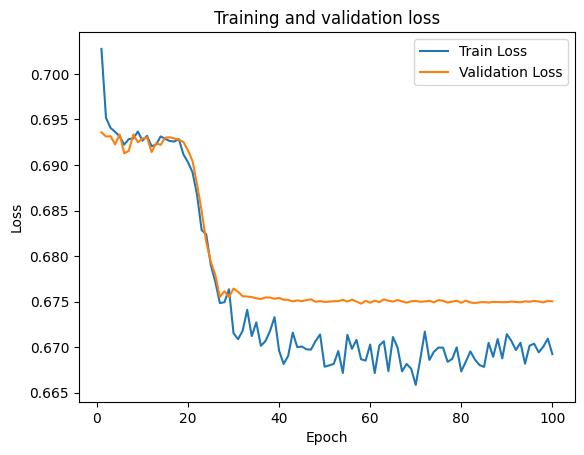

In [19]:
plt.plot(range(1, n_epochs+1), history['train']['Loss'], label='Train Loss')
plt.plot(range(1, n_epochs+1), history['val']['Loss'], label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

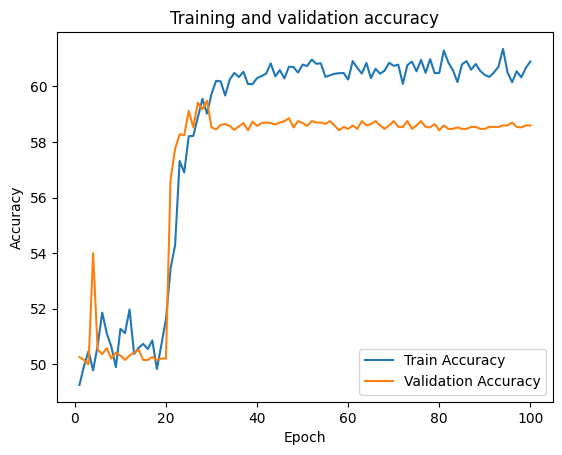

In [20]:
plt.plot(range(1, n_epochs+1), history['train']['Accuracy'], label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history['val']['Accuracy'], label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
model.eval()
test_losses, test_accs = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        
        test_loss = criterion(outputs, labels.unsqueeze(1))
        test_acc = binary_acc(outputs, labels.unsqueeze(1))
        
        test_losses.append(test_loss.item())
        test_accs.append(test_acc.item())

avg_test_loss = sum(test_losses) / len(test_losses)
avg_test_acc = sum(test_accs) / len(test_accs)
print(f"Average Test Loss: {avg_test_loss}")
print(f"Average Test Accuracy: {avg_test_acc}")

Average Test Loss: 0.6225199746150597
Average Test Accuracy: 71.23529411764706


In [38]:
models.append({'Name': 'RNN', 'File': 'TrainedModels/Recurrents/RNN.pt', 
               'model': model, 'Accuracy': avg_test_acc, 'Loss': avg_test_loss})

In [30]:
class BinaryLSTM(nn.Module):
    
    def __init__(self, input_size):
        super(BinaryLSTM, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size, input_size, batch_first=True)
        
        self.fc1 = nn.Linear(input_size, 6)
        self.fc2 = nn.Linear(6, 1)
        
        self.leaky = nn.LeakyReLU()
        
        self.batchnorm = nn.BatchNorm1d(6)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, inputs):
        x, _ = self.lstm1(inputs)
        
        x = self.batchnorm(self.fc1(x))
        x = self.leaky(x)
        
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        
        return x

In [31]:
model2 = BinaryLSTM(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [32]:
history2 = {'train': {'Loss': [], 'Accuracy': []}, 
           'val': {'Loss': [], 'Accuracy': []}}

print(f'[{" "*n_epochs}] ({0:.2f}%)', end='\r')
for epoch in range(1, n_epochs+1):
    for phase in ['train', 'val']:
        if phase == 'train':
            model2.train()
            
        else:
            model2.eval()
            
        epoch_loss = 0
        epoch_acc = 0
            
        for X_batch, y_batch in training_loaders[phase]:
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                y_pred = model2(X_batch)

                loss = criterion(y_pred, y_batch.unsqueeze(1))
                acc = binary_acc(y_pred, y_batch.unsqueeze(1))

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()


        if phase ==  'train':
            exp_lr_scheduler.step()
            
        hist_loss = epoch_loss/len(training_loaders[phase])
        history2[phase]['Loss'].append(hist_loss)
        hist_acc = epoch_acc/len(training_loaders[phase])
        history2[phase]['Accuracy'].append(hist_acc)
    
    print(f'[{"="*(epoch)}{" "*(n_epochs-epoch)}] ({((epoch)/n_epochs)*100:.2f}%)', end='\r')

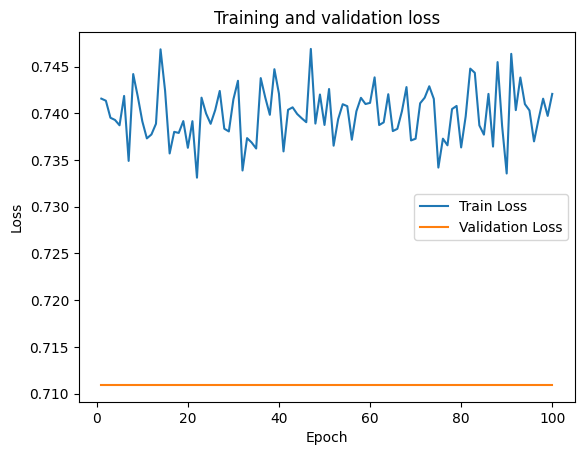

In [33]:
plt.plot(range(1, n_epochs+1), history2['train']['Loss'], label='Train Loss')
plt.plot(range(1, n_epochs+1), history2['val']['Loss'], label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

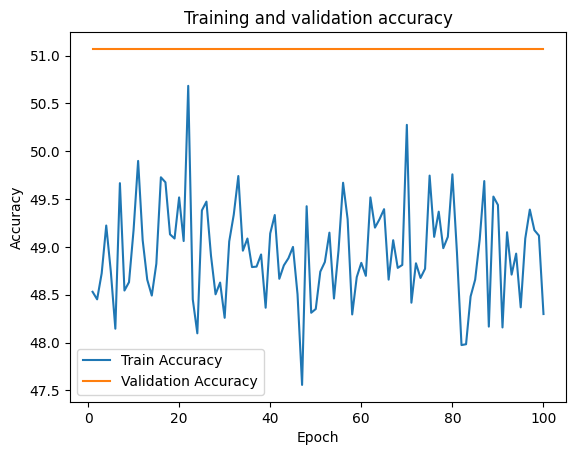

In [34]:
plt.plot(range(1, n_epochs+1), history2['train']['Accuracy'], label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history2['val']['Accuracy'], label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
model2.eval()
test_losses2, test_accs2 = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model2(inputs)
        
        test_loss = criterion(outputs, labels.unsqueeze(1))
        test_acc = binary_acc(outputs, labels.unsqueeze(1))
        
        test_losses2.append(test_loss.item())
        test_accs2.append(test_acc.item())

avg_test_loss2 = sum(test_losses2) / len(test_losses2)
avg_test_acc2 = sum(test_accs2) / len(test_accs2)
print(f"Average Test Loss: {avg_test_loss2}")
print(f"Average Test Accuracy: {avg_test_acc2}")

Average Test Loss: 0.7744480955834482
Average Test Accuracy: 45.84313725490196


In [39]:
models.append({'Name': 'LSTM', 'File': 'TrainedModels/Recurrents/LSTM.pt', 
               'model': model2, 'Accuracy': avg_test_acc2, 'Loss': avg_test_loss2})

## Models Review

In [40]:
models_df = pd.DataFrame(models)
models_df = models_df.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
models_df[['Name', 'Accuracy', 'Loss']]

,Name,Accuracy,Loss
0,RNN,74.705882,0.601422
1,LSTM,45.843137,0.774448


In [45]:
models_df.to_excel('TrainedModels/Recurrents/models.xlsx', index=0)

In [42]:
for idx, file in enumerate(models_df['File']):
    file_model = models_df.loc[models_df['File'] == file]['model'][idx]
    torch.save(file_model, file)

In [43]:
import joblib

In [44]:
scaler_file = 'Scalers/RNN.pkl'
joblib.dump(scaler, scaler_file, compress=True)

['Scalers/RNN.pkl']